In [ ]:
#| default_exp core
#| default_cls_lvl 3

In [ ]:
#| include: false
# %load_ext line_profiler
%matplotlib widget

# Application Structure
The data will be extracted and prepared via transforms. Those are grouped in:
- Type Transforms: Those extraxt the needed components from the source items, like input sequences or target scalar values. The work on single tensors.
- Item Transforms: Those Transforms may work on tuple level and therefore may process relationships between input and output.
- Batch Transform: Those transforms work on batch level. They receive batched tensors and may apply lazy transforms like normalization very effeciently.

An application example may look like the following:
- sourceitems: 
    - path extraction with hdf5 file endings
    - create pandas dataframe with information for type transforms, like slices
    - filter items in pandas dataframe
- type transforms: 
    - extract hdf5 input and output sequence
    - create windows
- item transforms: 
    - filter sequence by value
    - shift output sequence by 1 element
- batch transforms: 
    - noise injection
    - normalization
    

In [ ]:
#| export
from fastai.data.all import *
from fastai.vision.augment import RandTransform
import h5py

In [ ]:
#| export
def obj_in_lst(lst,cls):
    '''retrieve first object of type cls from a list'''
    return next(o for o in lst if type(o) is cls)

In [ ]:
#| export
def count_parameters(model):
    '''retrieve number of trainable parameters of a model'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 1. Extract Source Items
The file paths may be extracted with `get_files` of fastai2. `get_hdf_files` removes the need of writing the hdf5 file extension.

Then a pandas dataframe may be created in case further information for the source items need to be stored like slices for the windowing function.

### 1.1 Extract File Paths

In [ ]:
f_path = Path.cwd() / 'test_data/battery'
hdf_files = get_files(f_path,extensions='.hdf5',recurse=True)
len(hdf_files),hdf_files[0]

(3,
 Path('/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5'))

In [ ]:
#| export
hdf_extensions = ['.hdf5']
def get_hdf_files(path,recurse=True, folders=None):
    "Get hdf5 files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=hdf_extensions, recurse=recurse, folders=folders)

In [ ]:
hdf_files = get_hdf_files(f_path)
len(hdf_files),hdf_files[0]

(3,
 Path('/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5'))

### 1.2 Create Source Dictionaries
In order to extract mulitple realizations of one file with different modifications, we create a list of properties. Pandas Dataframes are to slow for iteration but very fast and convenient for creations. So after creation of the pandas Dataframe we convert it to a list of dictionaries.

In [ ]:
#| export
def apply_df_tfms(src,pd_tfms = None):
    '''Create Pandas Dataframe out of a list of items, with a list of df transforms applied'''
    if type(src) is pd.DataFrame:
        df = src
    else:
        df = pd.DataFrame(data=src.items,columns=['path'],dtype=str)
    if pd_tfms is not None:
        for t in pd_tfms:
            df = t(df)
    return df

In [ ]:
df = apply_df_tfms(hdf_files)
df.head()

,path
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5
1,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5


In [ ]:
test_eq(apply_df_tfms(hdf_files),apply_df_tfms(apply_df_tfms(hdf_files)))

In [ ]:
#| export
def CreateDict(pd_tfms = None):
    '''Create List of Dictionarys out of a list of items, with a list of df transforms applied'''
    def _inner(src):
        df = apply_df_tfms(src,pd_tfms)
#         df_dict_list = df.to_dict(orient='records') native to_dict is slower than self written approach
        df_values = df.values
        df_dict = {name:list(df_values[:,i]) for (i,name) in enumerate(df.columns)}
        df_dict_list = [{name: df_dict[name][i] for name in df_dict} for i in range(len(df))]
        return df_dict_list
    return _inner

In [ ]:
l_dict =CreateDict()(hdf_files)
l_dict

[{'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5'},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5'},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5'}]

In [ ]:
#| export
def ValidClmContains(lst_valid):
    '''add validation column using a list of strings that are part of the validation frames'''
    def _inner(df):
        re_valid = '|'.join([re.escape(f) for f in lst_valid])
        df['valid'] = df.path.str.contains(re_valid)
        return df

    return _inner

In [ ]:
%%time
lst_valid = ['valid']
CreateDict([ValidClmContains(lst_valid)])(hdf_files)

CPU times: user 1.09 ms, sys: 107 µs, total: 1.19 ms
Wall time: 1.19 ms


[{'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5',
  'valid': False},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5',
  'valid': False},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5',
  'valid': True}]

In [ ]:
#| export
def ValidClmIs(lst_valid):
    '''adds validation column using a list of validation filenames'''
    def _inner(df):
        df['valid'] = df.path.isin([str(f) for f in lst_valid])
        return df

    return _inner

In [ ]:
%%time
lst_valid = ['test_data/battery/train/Sim_RealisticCycle2.hdf5','test_data/battery/valid/Sim_RealisticCycle3.hdf5']
CreateDict([ValidClmIs(lst_valid)])(hdf_files)

CPU times: user 720 µs, sys: 0 ns, total: 720 µs
Wall time: 700 µs


[{'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5',
  'valid': False},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5',
  'valid': False},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5',
  'valid': False}]

In [ ]:
#| export
def FilterClm(clm_name,func = lambda x:x):
    '''adds validation column using a list of validation filenames'''
    def _inner(df):
        return df[func(df[clm_name])]

    return _inner

In [ ]:
CreateDict([ValidClmIs(lst_valid),FilterClm('valid')])(hdf_files)

[]

In [ ]:
#| export
def get_hdf_seq_len(df,clm,ds=None):
    '''extract the sequence length of the dataset with the 'clm' name and 'f_path' path  '''
    with h5py.File(df['path'],'r') as f:
        ds = f if 'dataset' not in df else f[df['dataset']]
        f_len = max(ds[clm].shape)
    return f_len 

In [ ]:
#| export
def df_get_hdf_seq_len(df,clm,ds=None):
    '''extracts the sequence length of every file in advance to prepare repeated window extractions with 'DfHDFCreateWindows' '''
#     df['seq_len'] = ([get_hdf_seq_len(row.path,clm) for (idx, row) in df.iterrows()])
    df['seq_len'] = df.apply(lambda x: get_hdf_seq_len(x,clm),axis=1)
    return df

In [ ]:
#| export
def DfHDFGetSeqLen(clm):
    def _inner(df):
        return df_get_hdf_seq_len(df,clm)
    return _inner

In [ ]:
df_get_hdf_seq_len(df,'current')

,path,seq_len
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607
1,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5,265598
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593


In [ ]:
DfHDFGetSeqLen('current')(df)

,path,seq_len
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607
1,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5,265598
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593


In [ ]:
#| export
import numbers
def DfResamplingFactor(src_fs,lst_targ_fs):
    if not isinstance(src_fs, numbers.Number) and not type(src_fs) is str: 
        raise ValueError('src_fs has to be a column name or a fixed number')
    
    def _inner(df):
        np_targ_fs = array(lst_targ_fs)
        pd.options.mode.chained_assignment = None #every row is a reference so we need to suppress the warning messages while copying

        #repeat entries for every target fs
        res_df = df.iloc[np.repeat(np.arange(len(df)),len(np_targ_fs))] 
        targ_fs = np.tile(np_targ_fs,len(df))
        res_df['targ_fs'] = targ_fs
        
        if isinstance(src_fs, numbers.Number):
            #src_fs is a fixed number
            res_df['resampling_factor'] = targ_fs/src_fs
        else:
            #src_fs is a column name of the df
            res_df['resampling_factor'] = targ_fs/res_df[src_fs]

        pd.options.mode.chained_assignment = 'warn'
        
        return res_df
    return _inner

In [ ]:
targ_fs = [50,100,300]
test_eq(len(DfResamplingFactor(100,targ_fs)(df)),9)   
df['src_fs'] = 200.
test_eq(len(DfResamplingFactor('src_fs',targ_fs)(df)),9)

In [ ]:
#| export
def DfHDFCreateWindows(win_sz,stp_sz, clm, fixed_start = False, fixed_end = False):
    '''create windows of sequences, splits sequence into multiple items'''
    def _inner(df):
        if fixed_start and fixed_end: raise Exception
        
        if 'seq_len' in df:
            np_f_len = df.seq_len.values
        else:
            np_f_len = np.array([get_hdf_seq_len(row,clm) for (idx, row) in df.iterrows()])
            
        if 'resampling_factor' in df: np_f_len =(np_f_len*df.resampling_factor.values).astype(int)
            
        n_win = ((np_f_len-win_sz)//stp_sz)+1
        #cast array n_win to int and clip negative values to 0
        n_win = n_win.astype(int)
        n_win = np.clip(n_win,a_min=0,a_max=None) #remove negative values at instances where the winsize is smaller than the seq_len
        lst_idx = np.arange(len(np_f_len))
        
        pd.options.mode.chained_assignment = None #every row is a reference so we need to suppress the warning messages while copying
        
        res_df = df.iloc[np.repeat(lst_idx,n_win)]
#         res_df = df.loc[np.repeat(lst_idx,n_win)] #the loc variant as a little bit slower because it creates copies and returns wrong values with redundant indexes, but is more robust

        step_idx = np.concatenate([np.arange(x) for x in n_win])
    
        
        res_df['l_slc'] = step_idx*stp_sz if not fixed_start else None
        res_df['r_slc'] = step_idx*stp_sz + win_sz if not fixed_end else None
            
        pd.options.mode.chained_assignment = 'warn'
            
        return res_df
    
    return _inner

In [ ]:
%%time
create_win = DfHDFCreateWindows(win_sz=100.2,stp_sz=100,clm='current')
win_df = create_win(df)
win_df

CPU times: user 1.21 ms, sys: 120 µs, total: 1.33 ms
Wall time: 1.14 ms


,path,seq_len,src_fs,l_slc,r_slc
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,0,100.2
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,100,200.2
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,200,300.2
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,300,400.2
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,400,500.2
...,...,...,...,...,...
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,265000,265100.2
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,265100,265200.2
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,265200,265300.2
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,265300,265400.2


In [ ]:
win_df = DfHDFCreateWindows(win_sz=265594,stp_sz=100,clm='current')(df)
test_eq(len(win_df),2)
win_df

,path,seq_len,src_fs,l_slc,r_slc
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,0,265594
1,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5,265598,200.0,0,265594


In [ ]:
test_eq(create_win(df_get_hdf_seq_len(df,'current')) , create_win(df))

In [ ]:
res_win_df = create_win(DfResamplingFactor(200,[0.1])(df))
res_win_df

,path,seq_len,src_fs,targ_fs,resampling_factor,l_slc,r_slc
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,0.1,0.0005,0,100.2
1,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5,265598,200.0,0.1,0.0005,0,100.2
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,0.1,0.0005,0,100.2


In [ ]:
test_eq(len(res_win_df),3)

In [ ]:
query_expr = 'l_slc <= 200'
filt_df = win_df.query(query_expr)
filt_df

,path,seq_len,src_fs,l_slc,r_slc
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,0,265594
1,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle2.hdf5,265598,200.0,0,265594


In [ ]:
#| export
def DfApplyFuncSplit(split_func,func1,func2):
    '''apply two different functions on the dataframe, func1 on the first indices of split_func, func2 on the second indices.
        Split_func is a Training, Validation split function'''
    def _inner(df):
        (idxs1,idxs2) = split_func(df.path)
        df1= func1(df.iloc[idxs1])
        df2= func2(df.iloc[idxs2])
        return pd.concat((df1,df2))
    return _inner

In [ ]:
create_win_split = DfApplyFuncSplit(
    IndexSplitter([1,2]),
    DfHDFCreateWindows(win_sz=10000,stp_sz=1,clm='current'),
    DfHDFCreateWindows(win_sz=10000,stp_sz=10000,clm='current')
)
create_win_split(df)

,path,seq_len,src_fs,l_slc,r_slc
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,0,10000
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,1,10001
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,2,10002
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,3,10003
0,/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5,265607,200.0,4,10004
...,...,...,...,...,...
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,210000,220000
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,220000,230000
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,230000,240000
2,/home/pheenix/Development/seqdata/test_data/battery/valid/Sim_RealisticCycle3.hdf5,265593,200.0,240000,250000


In [ ]:
#| export
def DfFilterQuery(query):
    def _inner(df):
        return df.query(query)
    return _inner

In [ ]:
test_eq(DfFilterQuery(query_expr)(win_df),filt_df)

In [ ]:
%%time
tfm_src = CreateDict([ValidClmContains(['valid']),DfHDFCreateWindows(win_sz=100+1,stp_sz=10,clm='current')])
src_dicts = tfm_src(hdf_files)
src_dicts[:5]

CPU times: user 52.7 ms, sys: 3.66 ms, total: 56.4 ms
Wall time: 56.1 ms


[{'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5',
  'valid': False,
  'l_slc': 0,
  'r_slc': 101},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5',
  'valid': False,
  'l_slc': 10,
  'r_slc': 111},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5',
  'valid': False,
  'l_slc': 20,
  'r_slc': 121},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5',
  'valid': False,
  'l_slc': 30,
  'r_slc': 131},
 {'path': '/home/pheenix/Development/seqdata/test_data/battery/train/Sim_RealisticCycle1.hdf5',
  'valid': False,
  'l_slc': 40,
  'r_slc': 141}]

In [ ]:
#| export
def DfDropClmExcept(clms = ['path','l_slc','r_slc','p_sample','resampling_factor']):
    '''drop unused dataframe columns as a last optional step to accelerate dictionary conversion'''
    def _inner(df):
        return df[[c for c in clms if c in df]]
    return _inner

## 2. Convert Paths to Sequence Objects
Der Pfad wird unter Angabe der Spaltennamen in Sequenzen und Skalare Werte umgewandelt, um so am Ende ein 3-Tupel zu erhalten aus:
- (Sequence, Scalar, Sequence) <-> (input,input,output)

### 2.1 Extract sequential data from hdf5-files
Two different functions, based on pandas df and on lists

#### 2.1.1 Shift time Series
Sometimes we need to shift columns of a sequence by a specific value. Then we cant simply slice the array but have to handle each column individually. First a performance test has to be made.

In [ ]:
#| export
def calc_shift_offsets(clm_shift):
    clm_shift = array(clm_shift)
    l_offs = -min(clm_shift.min(),0)
    r_offs = -max(clm_shift.max(),0)
    l_shift = clm_shift+l_offs
    r_shift = clm_shift+r_offs
    dim_red = l_offs-r_offs
    return l_shift,r_shift,dim_red

In [ ]:
shft = [0,0,-1,1]
calc_shift_offsets(shft)

(array([1, 1, 0, 2]), array([-1, -1, -2,  0]), 2)

both shifting methods have their own performance character. vstack needs double the time on short sequences, while the creation of a seperate array with copy becomes worse starting at around 5000 elements

In [ ]:
# ta = array([[1,2,3]*2]*10000)

In [ ]:
# %%timeit
# y = np.vstack([ta[i:-ta.shape[1]+i,i] for i in range(ta.shape[1])]).T   

In [ ]:
# %%timeit
# x = np.zeros((ta.shape[0]-ta.shape[1],ta.shape[1]))
# for i in range(ta.shape[1]):
#     x[:,i] = ta[i:-ta.shape[1]+i,i]

#### 2.1.2 HDF2Sequence
HDF5 performance is massively affected by the dtype of the signals. f4 (32 bit floating point) Numbers are faster to load and lead to smaller files then f8 numbers.

In [ ]:
#| export
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0,axis=0),axis=0) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
#| export
def downsample_mean(x,N):
    shp = x.shape
    trunc = -(x.shape[0] % N)
    trunc = trunc if trunc != 0 else None
    return x[:trunc,:].reshape((-1,N,x.shape[-1])).mean(axis=1)

In [ ]:
#| export
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal
def resample_interp(x,resampling_factor,sequence_first=True, lowpass_cut=1.0, upsample_cubic_cut = None):
    '''signal resampling using linear or cubic interpolation
    
    x: signal to resample with shape: features x resampling_dimension or resampling_dimension x  features if sequence_first=True
    resampling_factor: Factor > 0 that scales the signal
    lowpass_cut: Upper boundary for resampling_factor that activates the lowpassfilter, low values exchange accuracy for performance, default is 0.7
    upsample_cubic_cut: Lower boundary for resampling_factor that activates cubic interpolation at high upsampling values. 
                        Improves signal dynamics in exchange of performance. None deactivates cubic interpolation
    '''
    
    if sequence_first:
        x = x.T
    
    fs_n = resampling_factor
    #if downsampling rate is too high, lowpass filter before interpolation
    if fs_n < lowpass_cut:
        b,a = butter(2, fs_n)
        zi = lfilter_zi(b,a)*x[:,:1] #initialize filter with steady state at first time step value
        x,_ = lfilter(b,a,x,axis=-1,zi=zi)

#         sos = butter(2, fs_n*1.2,output='sos')
# #         sos = signal.cheby2(2,20, fs_n,output='sos')
# #         import pdb;pdb.set_trace()
#         zi = np.swapaxes(signal.sosfilt_zi(sos)[...,None]*x[:,0],1,2)
#         x,_ = signal.sosfilt(sos, x,axis=-1,zi=zi)
        
    x_int = tensor(x)[None,...]
    targ_size = int(x.shape[-1]*fs_n)
    
#     if upsampling rate is too high, switch from linear to cubic interpolation
    if upsample_cubic_cut is None or fs_n <= upsample_cubic_cut:
        x = array(nn.functional.interpolate(x_int, size=targ_size, mode='linear',align_corners=False)[0])
    else:
        x = array(nn.functional.interpolate(x_int[...,None], size=[targ_size,1], mode='bicubic',align_corners=False)[0,...,0])
#     x = array(x_int)[0]
    
    if sequence_first:
        x = x.T
    
    return x

In [ ]:
x = np.random.normal(size=(100000,9))
test_eq(resample_interp(x,0.3).shape[0],30000)

In [ ]:
# def plotFFT(buffer,sample_rate,label,fig=plt):
#     xf,yf = calcFFT(buffer,sample_rate)
#     fig.plot(xf, yf,label=label)
    
# def calcFFT(buffer,sample_rate):
#     N = buffer.shape[0]
#     T = 1.0 / sample_rate
#     x = np.linspace(0.0, N*T, N)
#     y = buffer
#     yf = scipy.fft.fft(y)
#     xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
#     return xf,2.0/N * np.abs(yf[:N//2])

# src_fs= 200
# n_fs = 0.9
# plt.figure()
# plotFFT(x[:,0],src_fs,'raw')
# plotFFT(resample_interp(x,n_fs)[:,0],n_fs*src_fs,'filtered')
# plt.legend()

In [ ]:
#| export
from scipy.signal import resample
def hdf_extract_sequence(hdf_path,clms,dataset = None, l_slc = None, r_slc= None, resampling_factor=None, fs_idx =None,dt_idx =False,fast_resample=True):
    '''
    extracts a sequence with the shape [seq_len x num_features]
    
    hdf_path: file path of hdf file, may be a string or path type
    clms: list of dataset names of sequences in hdf file
    dataset: dataset root for clms. Useful for multiples sequences stored in one file.
    l_slc: left boundary for extraction of a window of the whole sequence
    r_slc: right boundary for extraction of a window of the whole sequence
    resampling_factor: scaling factor for the sequence length, uses 'resample_interp' for resampling
    fs_idx: clms list idx of fs entry in sequence. Will be scaled by resampling_factor after resampling
    dt_idx: clms list idx of dt entry in sequence. Will be scaled by resampling_factor after resampling
    fast_resample: if True, uses linear interpolation with anti-aliasing filter for faster resampling. Is less accurate than fft based resampling
    '''

    if resampling_factor is not None:
        seq_len = r_slc-l_slc if l_slc is not None and r_slc is not None else None #calculate seq_len for later slicing, necesary because of rounding errors in resampling
        if l_slc is not None: l_slc= math.floor(l_slc/resampling_factor)
        if r_slc is not None: r_slc= math.ceil(r_slc/resampling_factor)

    with h5py.File(hdf_path,'r') as f:
        ds = f if dataset is None else f[dataset]
        l_array = [(ds[n][l_slc:r_slc]) for n in clms]
        seq = np.stack(l_array,axis=-1)

    if resampling_factor is not None:
        if fast_resample:
            res_seq = resample_interp(seq,resampling_factor)
        else:
            res_seq = resample(seq,int(seq.shape[0]*resampling_factor),window=('kaiser', 14.0))
        if fs_idx is not None: res_seq[:,fs_idx] = seq[0,fs_idx] * resampling_factor
        if dt_idx is not None: res_seq[:,dt_idx] = seq[0,dt_idx] / resampling_factor
        seq = res_seq
        
        if seq_len is not None: seq = seq[:seq_len] #cut the part of the sequence that is too long because of resampling rounding errors
        
    return seq

In [ ]:
#| export
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}

    def __call__(self, *args):
        if args not in self.memo:
            self.memo[args] = self.fn(*args)
        return self.memo[args]



In [ ]:
#| export
from multiprocessing import shared_memory, Manager, Lock
import weakref

class MemoizeMP:
    def __init__(self, fn):
        self.fn = fn
        self.manager = Manager()
        self.results_dict = self.manager.dict()  # Stores metadata about computed results
        self.lock = Lock()  # Ensure atomic updates to the results_dict
        self.local_memo = {}  # Local cache for each process

    def __call__(self, *args):
        # First, attempt to return the result from the local cache to avoid unnecessary locking
        if args in self.local_memo:
            result, _ = self.local_memo[args]
            return result

        with self.lock:
            if args in self.results_dict:
                result_info = self.results_dict[args]
                existing_shm = shared_memory.SharedMemory(name=result_info['name'])
                result = np.ndarray(result_info['shape'], dtype=result_info['dtype'], buffer=existing_shm.buf)
                # Register the shared memory for cleanup without removing it from the dictionary
                self.local_memo[args] = (result, existing_shm)
                # Using a weakref finalizer to ensure cleanup when the numpy array is no longer in use
                weakref.finalize(result, self.cleanup_shared_memory, result_info['name'])
                return result

        result = self.fn(*args)


        with self.lock:
            if args not in self.results_dict:
                result_shm = shared_memory.SharedMemory(create=True, size=result.nbytes)
                shm_array = np.ndarray(result.shape, dtype=result.dtype, buffer=result_shm.buf)
                shm_array[:] = result[:]
                
                self.results_dict[args] = {
                    'name': result_shm.name,
                    'shape': result.shape,
                    'dtype': result.dtype.str
                }
                self.local_memo[args] = (result, result_shm)
                # Register cleanup for the newly created shared memory block
                weakref.finalize(result, self.cleanup_shared_memory, result_shm.name)

        return result

    def cleanup_shared_memory(self, shm_name):
        """Cleanup a specific shared memory block."""
        try:
            shm = shared_memory.SharedMemory(name=shm_name)
            shm.close()
            shm.unlink()
        except FileNotFoundError:
            # Handle the case where the shared memory block is already cleaned up
            pass

In [ ]:
#| export
class HDF2Sequence(Transform):
    
    def __init__(self, clm_names,clm_shift=None,truncate_sz=None,to_cls=noop,cached=True, fs_idx =None,dt_idx =None,fast_resample=True):
        if not clm_shift is None:
            assert len(clm_shift)==len(clm_names) and all(isinstance(n, int) for n in clm_shift)
            self.l_shift,self.r_shift,_ = calc_shift_offsets(clm_shift)
        
        if not cached:
            self._exseq = self._hdf_extract_sequence 
        elif cached == 'local':
            self._exseq = Memoize(self._hdf_extract_sequence) 
        else :
            self._exseq = MemoizeMP(self._hdf_extract_sequence)

        self.cached = cached is not None
        store_attr('clm_names,clm_shift,truncate_sz,to_cls,fs_idx,dt_idx,fast_resample')
        
    def _hdf_extract_sequence(self,hdf_path,dataset = None, l_slc = None, r_slc= None, resampling_factor=None, fs_idx =None,dt_idx =None,fast_resample=True):
        '''
        extracts a sequence with the shape [seq_len x num_features]

        hdf_path: file path of hdf file, may be a string or path type
        clms: list of dataset names of sequences in hdf file
        dataset: dataset root for clms. Useful for multiples sequences stored in one file.
        l_slc: left boundary for extraction of a window of the whole sequence
        r_slc: right boundary for extraction of a window of the whole sequence
        resampling_factor: scaling factor for the sequence length, uses 'resample_interp' for resampling
        fs_idx: clms list idx of fs entry in sequence. Will be scaled by resampling_factor after resampling
        dt_idx: clms list idx of dt entry in sequence. Will be scaled by resampling_factor after resampling
        fast_resample: if True, uses linear interpolation with anti-aliasing filter for faster resampling. Is less accurate than fft based resampling
        '''

        if resampling_factor is not None:
            seq_len = r_slc-l_slc if l_slc is not None and r_slc is not None else None #calculate seq_len for later slicing, necesary because of rounding errors in resampling
            if l_slc is not None: l_slc= math.floor(l_slc/resampling_factor)
            if r_slc is not None: r_slc= math.ceil(r_slc/resampling_factor)

        with h5py.File(hdf_path,'r') as f:
            ds = f if dataset is None else f[dataset]
            l_array = [(ds[n][l_slc:r_slc]) for n in self.clm_names]
            seq = np.stack(l_array,axis=-1)

        if resampling_factor is not None:
            if fast_resample:
                res_seq = resample_interp(seq,resampling_factor)
            else:
                res_seq = resample(seq,int(seq.shape[0]*resampling_factor),window=('kaiser', 14.0))
            
            if fs_idx is not None: res_seq[:,fs_idx] = seq[0,fs_idx] * resampling_factor
            if dt_idx is not None: res_seq[:,dt_idx] = seq[0,dt_idx] / resampling_factor
            seq = res_seq

            if seq_len is not None: seq = seq[:seq_len] #cut the part of the sequence that is too long because of resampling rounding errors

        return seq
    
    def _extract_dict_sequence(self,item):
        if hasattr(item,'keys'):
            path = item['path']
            dataset = item['dataset'] if 'dataset' in item else None
            l_slc = item['l_slc'] if 'l_slc' in item else None
            r_slc = item['r_slc'] if 'r_slc' in item else None
            resampling_factor = item['resampling_factor'] if 'resampling_factor' in item else None

            if self.cached:
                seq = self._exseq(path,dataset,None,None,resampling_factor,self.fs_idx,self.dt_idx,self.fast_resample)[l_slc:r_slc]
            else:
                seq = self._exseq(path,dataset,l_slc,r_slc,resampling_factor,self.fs_idx,self.dt_idx,self.fast_resample)
        else:
            seq = self._exseq(str(item),None,None,None,None,None)

        #shift clms of result by given value 
        if not self.clm_shift is None:
            l_seq = seq.shape[0]
            seq = np.stack([seq[self.l_shift[i]:l_seq+self.r_shift[i],i] for i in range(seq.shape[1])],axis=-1)
            
        if not self.truncate_sz is None:
            seq = seq[truncate_sz:]
        
        #it is important to slice first and then do the class conversion
#         return self.to_cls(seq.astype('f8'))#workaround for random bug, that mitigates convergence if the numpy array is an f4 array. Seems to make no sense because the result does not change. 
        return self.to_cls(seq)

    def encodes(self, item)->None: 
        return self._extract_dict_sequence(item)

In [ ]:
# %%timeit
hdf2seq = HDF2Sequence(['current','voltage'],cached=False)
hdf2seq(hdf_files[0])

array([[ 0.       ,  4.1873503],
       [-0.1      ,  4.18935  ],
       [-0.1      ,  4.1896954],
       ...,
       [ 8.8388   ,  3.3932123],
       [ 8.846    ,  3.3928714],
       [ 8.8531   ,  3.3925302]], dtype=float32)

In [ ]:
hdf2seq = HDF2Sequence(['current','voltage'],clm_shift=[1,1])
hdf2seq(hdf_files[0])

array([[-0.1      ,  4.18935  ],
       [-0.1      ,  4.1896954],
       [-0.1      ,  4.190037 ],
       ...,
       [ 8.8388   ,  3.3932123],
       [ 8.846    ,  3.3928714],
       [ 8.8531   ,  3.3925302]], dtype=float32)

In [ ]:
hdf2seq = HDF2Sequence(['current','voltage'],cached='shared')
hdf2seq(hdf_files[0])

array([[ 0.       ,  4.1873503],
       [-0.1      ,  4.18935  ],
       [-0.1      ,  4.1896954],
       ...,
       [ 8.8388   ,  3.3932123],
       [ 8.846    ,  3.3928714],
       [ 8.8531   ,  3.3925302]], dtype=float32)

In [ ]:
# %%timeit
hdf2seq(hdf_files[0])

array([[ 0.       ,  4.1873503],
       [-0.1      ,  4.18935  ],
       [-0.1      ,  4.1896954],
       ...,
       [ 8.8388   ,  3.3932123],
       [ 8.846    ,  3.3928714],
       [ 8.8531   ,  3.3925302]], dtype=float32)

In [ ]:
hdf2seq = HDF2Sequence(['current','voltage'],cached=True)

In [ ]:
# %%timeit
hdf2seq(hdf_files[0])

array([[ 0.       ,  4.1873503],
       [-0.1      ,  4.18935  ],
       [-0.1      ,  4.1896954],
       ...,
       [ 8.8388   ,  3.3932123],
       [ 8.846    ,  3.3928714],
       [ 8.8531   ,  3.3925302]], dtype=float32)

Die Funktion lässt sich mittels Pipeline auf eine Liste von Quellobjekten (hier Pfade) anwenden 

In [ ]:
hdf2seq = HDF2Sequence(['current'])
hdf2seq(hdf_files[0]).shape

(265607, 1)

In [ ]:
pipe = Pipeline(HDF2Sequence(['current','voltage']))

In [ ]:
# res_pipe = pipe(hdf_files)
# len(res_pipe), res_pipe[0][0]

#### Performance Test
Caching stores the arrays for future use at every function call. Very usefull, especially for windows. Should allways be turned. Only explicitly turn it off when there is not enough memory for your data.

In [ ]:
tfms=[  [HDF2Sequence(['current','voltage'],cached=None)],
        [HDF2Sequence(['voltage'],cached=None)]]
dsrc = Datasets(src_dicts[:1000],tfms=tfms)

In [ ]:
len(dsrc)

1000

In [ ]:
# %%time
# for x in dsrc:
#     x

In [ ]:
tfms=[  [HDF2Sequence(['current','voltage'],cached=True,clm_shift=[1,2])],
        [HDF2Sequence(['voltage'],cached=True)]]
dsrc = Datasets(src_dicts[:1000],tfms=tfms)

In [ ]:
# %%timeit
for x in dsrc:
    x

Caching is way faster because every file gets loaded multiple times

### Extract Scalar data from hdf5-files

In [ ]:
#| export
def hdf2scalars(hdf_path,c_names,dataset = None):
    with h5py.File(hdf_path,'r') as f:
        ds = f if dataset is None else f[dataset]
        l_array = [ds.attrs[n] for n in c_names]
        scalars = np.stack(l_array,axis=-1)
#         import pdb; pdb.set_trace()
#         l_array = [f[n][:][:,None] for n in c_names]
#         seq = np.concatenate(l_array,axis=1)
        return scalars

In [ ]:
# hdf2scalars('/mnt/data/sicwell/hdf5/Cycles/ch3/cycle00568.hdf5',['soc','temperature1'],dataset='measurement_00000')

In [ ]:
#| export
class HDF2Scalars(Transform):
    
    def __init__(self, clm_names,to_cls=noop):
        store_attr('clm_names,to_cls')
    
    def _extract_dict_scalars(self,item):
        if isinstance(item,dict):
            path = item['path']
            dataset = item['dataset'] if 'dataset' in item else None

            seq = hdf2scalars(path,self.clm_names,dataset)
        else:
            seq = hdf2scalars(str(item),self.clm_names)
        return self.to_cls(seq)

    def encodes(self, item)->None: 
        return self._extract_dict_scalars(item)

In [ ]:
# HDF2Scalars(['soc','temperature1'])({'path':'/mnt/data/sicwell/hdf5/Cycles/ch3/cycle00568.hdf5','dataset':'measurement_00000'})

### Extract Scalar from sequence

In [ ]:
#| export
class ScalarSequenceElement(Transform):
    
    def __init__(self, idx,to_cls=noop):
        store_attr('idx,to_cls')

    def encodes(self, item)->None: 
        return self.to_cls(item[self.idx])

In [ ]:
ScalarSequenceElement(-1)(hdf2seq(hdf_files[0]))

array([8.8531], dtype=float32)

### 2.1 Datatypes for Sequences and Scalars

In [ ]:
#| export
class TensorSequences(TensorBase):#TensorBase
#     def __init__(self,x,c_names=None, **kwargs):
#         super().__init__()
#         self.c_names = c_names
    
    def show(self, ctx=None, **kwargs):
#         import pdb; pdb.set_trace()
        ax = ctx
        if ax is None: _,ax = plt.subplots()
        ax.plot(self)
#         if title is not None: ax.set_title(title)
        return ax

    @classmethod
    @delegates(HDF2Sequence, keep=True)
    def from_hdf(cls,clm_names,**kwargs):
        return HDF2Sequence(clm_names,**kwargs)
    
class TensorSequencesInput(TensorSequences): pass
class TensorSequencesOutput(TensorSequences): pass

In [ ]:
f = TensorSequencesInput.from_hdf(['current'])
type(f(hdf_files[0]))

numpy.ndarray

In [ ]:
# TensorSequences(np.ones((30,2))).show()

In [ ]:
#| export
@Transform
def toTensorSequencesInput(o): return TensorSequencesInput(o)
@Transform
def toTensorSequencesOutput(o): return TensorSequencesOutput(o)

In [ ]:
#| export
class TensorScalars(TensorBase):
    @classmethod
    @delegates(HDF2Scalars, keep=True)
    def from_hdf(cls,clm_names,**kwargs):
        return HDF2Scalars(clm_names,**kwargs)
    
    
class TensorScalarsInput(TensorScalars): pass
class TensorScalarsOutput(TensorScalars): pass


The tensor subclassing mechanism since pytorch 1.7 keeps the tensor type in tensor operations. Operations with different branches of subclasses of tensors require a implementation of '__torch_function__'.
Fastai implements 'TensorBase.register_func' to mark methods that behave for the given types like the default torch operation.

https://pytorch.org/docs/stable/notes/extending.html#extending-torch


In [ ]:
#| export
for f in torch.nn.functional.mse_loss,torch.nn.functional.huber_loss, Tensor.__getitem__, Tensor.__ne__,Tensor.__eq__,Tensor.add,Tensor.sub,Tensor.mul,Tensor.div,Tensor.__rsub__,Tensor.__radd__,Tensor.matmul,Tensor.bmm:
    TensorBase.register_func(f,TensorSequences)
    TensorBase.register_func(f,TensorScalars)

In [ ]:
x1 = TensorSequencesInput(torch.rand((10,10)))
x2 = TensorSequencesOutput(torch.rand((10,10)))
torch.nn.functional.mse_loss(x1,x2)

TensorSequencesInput(0.1628)

## 3. Transformations


### 3.1 Sequence Slicing Transformation

In [ ]:
#| export 
class SeqSlice(Transform):
    '''Take a slice from an array-like object. Useful for e.g. shifting input and output'''
    def __init__(self, l_slc=None,r_slc=None):
        self.l_slc,self.r_slc = l_slc,r_slc
        
    def encodes(self, o): return o[self.l_slc:self.r_slc]

In [ ]:
l_shift = SeqSlice(r_slc=-1)
arr = np.ones((5))
test_eq(l_shift(arr),arr[:-1])

### 3.2 Sequence Noise Injection Transformation

In [ ]:
#| export
class SeqNoiseInjection(RandTransform):
    split_idx=0 #apply only to training data, if None it will be applied to all data
    '''Adds normal distributed noise to the tensor sequence with seperate mean and std for every signal'''
    def __init__(self, std=1e-1,mean=0.,p=1.0):
        super().__init__(p=p)
        self.std = tensor(std).type(torch.float)
        self.mean = tensor(mean).type(torch.float)
        
    def encodes(self, o:TensorSequencesInput): 
        if o.device != self.mean.device:
            self.std = self.std.to(o.device)
            self.mean = self.mean.to(o.device)
        #expand creates a view on a tensor and is therefore very fast compared to copy
        return o+torch.normal(mean=self.mean.expand_as(o), 
                              std=self.std.expand_as(o))

In [ ]:
x = TensorSequencesInput(tensor([[1,1,1],[-1,-1,-1.0]]))
ns_mean = tensor([0.,10.1,3.1])
ns_std = tensor([1.,1.1,0.1])
x,x.shape

(TensorSequencesInput([[ 1.,  1.,  1.],
                       [-1., -1., -1.]]),
 torch.Size([2, 3]))

In [ ]:
seq_noise = SeqNoiseInjection(std=ns_std,mean=ns_mean)
seq_noise(x)

TensorSequencesInput([[ 1.,  1.,  1.],
                      [-1., -1., -1.]])

In [ ]:
seq_noise = SeqNoiseInjection(std=ns_std*10)
seq_noise(x)

TensorSequencesInput([[ 1.,  1.,  1.],
                      [-1., -1., -1.]])

In [ ]:
#| export
class SeqNoiseInjection_Varying(RandTransform):
    split_idx=0
    '''Adds normal distributed noise to the tensor sequence with a normal distributed standard deviation for every application'''
    def __init__(self, std_std=0.1,p=1.0):
        super().__init__(p=p)
        self.std_std = tensor(std_std).type(torch.float)
        
    def encodes(self, o:TensorSequencesInput): 
        if o.device != self.std_std.device:
            self.std_std = self.std_std.to(o.device)
            
        #expand creates a view on a tensor and is therefore very fast compared to copy
        std = torch.normal(mean=0,std=self.std_std).abs()
        return o+torch.normal(mean=0,std=std.expand_as(o))

In [ ]:
x = TensorSequencesInput(tensor([[0,0,0],[0,0,0]]))
ns_std = tensor([1.,1.1,0.1])
x,x.shape

(TensorSequencesInput([[0, 0, 0],
                       [0, 0, 0]]),
 torch.Size([2, 3]))

In [ ]:
seq_noise = SeqNoiseInjection_Varying(std_std=ns_std)
seq_noise(x)

TensorSequencesInput([[0, 0, 0],
                      [0, 0, 0]])

In [ ]:
#| export
class SeqNoiseInjection_Grouped(RandTransform):
    split_idx=0
    '''Adds normal distributed noise to the tensor sequence with a normal distributed standard deviation for every application, every group gert'''
    def __init__(self, std_std,std_idx,p=1.0):
        super().__init__(p=p)
        self.std_std = tensor(std_std).type(torch.float)
        self.std_idx = tensor(std_idx).type(torch.long)
        
    def encodes(self, o:TensorSequencesInput): 
        if o.device != self.std_std.device:
            self.std_std = self.std_std.to(o.device)
            
        #expand creates a view on a tensor and is therefore very fast compared to copy
        std = torch.normal(mean=0,std=self.std_std).abs()[self.std_idx]
        return o+torch.normal(mean=0,std=std.expand_as(o))

In [ ]:
x = TensorSequencesInput(tensor([[0,0,0],[0,0,0]]))
ns_std = tensor([1.,1.1,0.1])
x,x.shape

(TensorSequencesInput([[0, 0, 0],
                       [0, 0, 0]]),
 torch.Size([2, 3]))

In [ ]:
seq_noise = SeqNoiseInjection_Grouped(std_std=[3.,0],std_idx=[0,0,1])
seq_noise(x)

TensorSequencesInput([[0, 0, 0],
                      [0, 0, 0]])

### 3.2 Sequence Bias Injection Transformation

In [ ]:
#| export
class SeqBiasInjection(RandTransform):
    split_idx=0
    '''Adds a normal distributed offset to the tensor sequence with seperate mean and std for every signal'''
    def __init__(self, std=1e-1,mean=0.,p=1.0):
        super().__init__(p=p)
        self.std = tensor(std).type(torch.float)
        self.mean = tensor(mean).type(torch.float)
        
    def encodes(self, o:TensorSequencesInput): 
        if o.device != self.mean.device:
            self.std = self.std.to(o.device)
            self.mean = self.mean.to(o.device)
        
        #expand creates a view on a tensor and is therefore very fast compared to copy
        mean=self.mean.repeat((o.shape[0],1,1)).expand((o.shape[0],1,o.shape[2]))
        std= self.std.repeat((o.shape[0],1,1)).expand((o.shape[0],1,o.shape[2]))
        n = torch.normal(mean=mean, std=std).expand_as(o)
        return o+n

In [ ]:
x = TensorSequencesInput(tensor([[[1,1,1],[-1,-1,-1.0]]]))
ns_mean = tensor([0.,10.1,3.1])
ns_std = tensor([1.,1.1,0.1])
seq_bias = SeqBiasInjection(std=ns_std,mean=ns_std)
seq_bias(x)[...,0]

TensorSequencesInput([[ 1., -1.]])

In [ ]:
seq_bias.mean

tensor([1.0000, 1.1000, 0.1000])

In [ ]:
seq_bias = SeqBiasInjection(std=ns_std*10)
seq_bias(x)

TensorSequencesInput([[[ 1.,  1.,  1.],
                       [-1., -1., -1.]]])

### 3.3 Normalization
`Normalize` is programmed for `TensorImage` as an input tensor. It gets. At init the variable axes need to be chosen correspondingly to the shape of your tensor.

In [ ]:
#| export
@Normalize
def encodes(self, x:TensorSequencesInput): 
    if x.device != self.mean.device:
        self.mean = self.mean.to(x.device)
        self.std = self.std.to(x.device)
    return (x-self.mean) / self.std

@Normalize
def decodes(self, x:TensorSequencesInput):
    if x.device != self.mean.device:
        self.mean = self.mean.to(x.device)
        self.std = self.std.to(x.device)
    return (x*self.std + self.mean)

In [ ]:
norm = Normalize.from_stats(mean=ns_mean,std=ns_std,dim=1,ndim=2,cuda=False)
x,norm(x)

(TensorSequencesInput([[[ 1.,  1.,  1.],
                        [-1., -1., -1.]]]),
 TensorSequencesInput([[[  1.0000,  -8.2727, -21.0000],
                        [ -1.0000, -10.0909, -41.0000]]]))

## 4. Split in Training, Validation
Splitting kann anhand von vorher bekannten Indizes, dem Dateipfad oder anderen allgemeinen Funktion durchgeführt werden.

Splitting innerhalb einer Sequenzen sollte in der Praxis nur dann geschehen wenn eine einzige Sequenz vorhanden ist. Diese kann dann vorher manuell geteilt werden.


### 4.1 Splitting mit vorgegebenem Index

In [ ]:
splitter = IndexSplitter([1,2])
test_eq(splitter(hdf_files),[[0],[1,2]])

### 4.2 Splitting mit allgemeiner Funktion
Items, bei denen die definierte Funktion `True` zurück gibt, werden den Validierungsdatensatz zugeordnet, der Rest dem Training. In diesem Fall wird nach dem Übergeordneten Ordnernamen gesucht.

In [ ]:
splitter = FuncSplitter(lambda o: Path(o).parent.name == 'valid')
test_eq(splitter(hdf_files),[[0,1],[2]])

### 4.3 Splitting anhand des Parent-Folders
Splitter, der Explizit Training und Validierungsordner den Datensätzen zuordnet

In [ ]:
#| export
def _parent_idxs(items, name): return mask2idxs(Path(o).parent.name == name for o in items)

def ParentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _parent_idxs(o, train_name),_parent_idxs(o, valid_name)
    return _inner

In [ ]:
splitter = ParentSplitter()
test_eq(splitter(hdf_files),[[0,1],[2]])

### 4.4 Percentage Splitter

In [ ]:
#| export
def PercentageSplitter(pct=0.8):
    "Split `items` in order in relative quantity."
    def _inner(o, **kwargs):
        split_idx=int(len(o)*pct)
        return L(range(split_idx)),L(range(split_idx,len(o)))
    return _inner

In [ ]:
splitter = PercentageSplitter(0.7)
test_eq(splitter(hdf_files),[[0,1],[2]])

### 4.5 Apply To Dictionary
In Case of the Datablock API your items are a list of dictionaries. If you want to apply a Splitter to the path stored within you need a wrapper function.

In [ ]:
#| export
def ApplyToDict(fn,key='path'):
    return lambda x:fn([i[key] for i in x])

### 4.6 Valid Column
Using the 'valid' column of the Dataframe that has been created by a transformation.

In [ ]:
#| export
valid_clm_splitter =  FuncSplitter(lambda o:o['valid'])

In [ ]:
valid_clm_splitter(src_dicts)

((#53101) [0,1,2,3,4,5,6,7,8,9...],
 (#26550) [53101,53102,53103,53104,53105,53106,53107,53108,53109,53110...])

## 5. Dataloaders Creation
A Datasets combines all implemented components on item level.

In [ ]:
#| export
def pad_sequence(batch,sorting = False):
    '''collate_fn for padding of sequences of different lengths, use in before_batch of databunch, still quite slow'''
    #takes list of tuples as input, returns list of tuples
    sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True) if sorting else batch

    pad_func = partial(torch.nn.utils.rnn.pad_sequence,batch_first=True)
    padded_tensors = [pad_func([x[tup] for x in sorted_batch]) for tup in range(len(batch[0]))]
    padded_list = [retain_types(tuple([tup[entry] for tup in padded_tensors]),batch[0]) for entry in range(len(batch))]
    #retain types is important for decoding later back to source items
#     import pdb; pdb.set_trace()
    
    return padded_list

### 5.1 Low-Level with Transforms

In [ ]:
tfms=[  [HDF2Sequence(['current','voltage']),SeqSlice(l_slc=1),toTensorSequencesInput],
        [HDF2Sequence(['voltage']),SeqSlice(r_slc=-1),toTensorSequencesOutput]]
splits = splitter([x['path'] for x in src_dicts])
dsrc = Datasets(src_dicts,tfms=tfms,splits=splits)

In [ ]:
# %%timeit
# dsrc[0]

In [ ]:
db = dsrc.dataloaders(bs=128,after_batch=[SeqNoiseInjection(std=[1.1,0.01]),Normalize(axes=[0,1])],before_batch=pad_sequence)
db.one_batch()[0].shape

torch.Size([128, 100, 2])

### 5.2 Mid-Level with Datablock API

In [ ]:
#| export
class SequenceBlock(TransformBlock):
    def __init__(self, seq_extract,padding=False):
        return super().__init__(type_tfms=[seq_extract],
                                batch_tfms=[Normalize(axes=[0,1])],
                                dls_kwargs={} if not padding else {'before_batch': pad_sequence})

    @classmethod
    @delegates(HDF2Sequence, keep=True)
    def from_hdf(cls, clm_names, seq_cls=TensorSequencesInput,padding=False, **kwargs):
        return cls(HDF2Sequence(clm_names,to_cls=seq_cls,**kwargs), padding)

    @classmethod
    def from_numpy(cls, seq_cls=TensorSequencesInput,padding=False, **kwargs):
        return cls(ToTensor(enc=seq_cls), padding)

In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,padding=True,cached=None),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput,cached=None)),
                get_items=tfm_src,
                splitter=ApplyToDict(ParentSplitter()))

In [ ]:
dls = seq.dataloaders(hdf_files)

In [ ]:
#| export
class ScalarNormalize(DisplayedTransform):
    def __init__(self, mean=None, std=None, axes=(0,)): store_attr()
        
    @classmethod
    def from_stats(cls, mean, std, dim=1, ndim=4, cuda=True): return cls(*broadcast_vec(dim, ndim, mean, std, cuda=cuda))
    
    def setups(self, dl:DataLoader):
        if self.mean is None or self.std is None:
            b = dl.one_batch()
            for x in b:
                if isinstance(x,TensorScalarsInput):
                    self.mean,self.std = x.mean(self.axes, keepdim=True),x.std(self.axes, keepdim=True)+1e-7
                    return

    def encodes(self, x:TensorScalarsInput): 
        if x.device != self.mean.device:
            self.mean = self.mean.to(x.device)
            self.std = self.std.to(x.device)
        return (x-self.mean) / self.std
    
    def decodes(self, x:TensorScalarsInput):
        if x.device != self.mean.device:
            self.mean = self.mean.to(x.device)
            self.std = self.std.to(x.device)
        return (x*self.std + self.mean)

class ScalarBlock(TransformBlock):
    def __init__(self, scl_extract):
        return super().__init__(type_tfms=[scl_extract],
                                batch_tfms=[ScalarNormalize()])

    @classmethod
    @delegates(HDF2Scalars, keep=True)
    def from_hdf(cls, clm_names, scl_cls=TensorScalarsInput, **kwargs):
        return cls(HDF2Scalars(clm_names,to_cls=scl_cls,**kwargs))

### 5.3 Spectrogram-Datablock

In [ ]:
#| export
class TensorSpectrogram(TensorBase):
    def show(self, ctx=None, ax=None, title="", **kwargs):
        ax = ifnone(ax, ctx)
        if ax is None:
            _, ax = plt.subplots()
        ax.axis(False)
        n_channels = self.shape[0]
        for i, channel in enumerate(self):
            ia = ax.inset_axes((i / n_channels, 0.2, 1 / n_channels, 0.7))
#             ia = ax.inset_axes((i / n_channels, 0, 1 / n_channels, 1))
    
            ia.imshow(channel.cpu().numpy(),aspect ='auto',origin ='lower')
            if i>0: ia.set_yticks([])
            ia.set_title(f"Channel {i}")
        ax.set_title(title)
        return ax

class TensorSpectrogramInput(TensorSpectrogram): pass
class TensorSpectrogramOutput(TensorSpectrogram): pass

In [ ]:
seq_spec = TensorSpectrogramInput(HDF2Sequence(['current'],to_cls=TensorSpectrogramInput)._hdf_extract_sequence(hdf_files[0],r_slc=2000))
seq_spec.shape

torch.Size([2000, 1])

In [ ]:
#| exporti
def complex_norm(
        complex_tensor: Tensor,
        power: float = 1.0
) -> Tensor:
    r"""Compute the norm of complex tensor input.

    Args:
        complex_tensor (Tensor): Tensor shape of `(..., complex=2)`
        power (float): Power of the norm. (Default: `1.0`).

    Returns:
        Tensor: Power of the normed input tensor. Shape of `(..., )`
    """
    if power == 1.0:
        return torch.norm(complex_tensor, 2, -1)
    return torch.norm(complex_tensor, 2, -1).pow(power)

In [ ]:
#| exporti
def spectrogram(
        waveform: Tensor,
        pad: int,
        window: Tensor,
        n_fft: int,
        hop_length: int,
        win_length: int,
        power: Optional[float],
        normalized: bool
) -> Tensor:
    r"""Create a spectrogram or a batch of spectrograms from a raw audio signal.
    The spectrogram can be either magnitude-only or complex.

    Args:
        waveform (Tensor): Tensor of audio of dimension (..., time)
        pad (int): Two sided padding of signal
        window (Tensor): Window tensor that is applied/multiplied to each frame/window
        n_fft (int): Size of FFT
        hop_length (int): Length of hop between STFT windows
        win_length (int): Window size
        power (float or None): Exponent for the magnitude spectrogram,
            (must be > 0) e.g., 1 for energy, 2 for power, etc.
            If None, then the complex spectrum is returned instead.
        normalized (bool): Whether to normalize by magnitude after stft

    Returns:
        Tensor: Dimension (..., freq, time), freq is
        ``n_fft // 2 + 1`` and ``n_fft`` is the number of
        Fourier bins, and time is the number of window hops (n_frame).
    """

    if pad > 0:
        # TODO add "with torch.no_grad():" back when JIT supports it
        waveform = torch.nn.functional.pad(waveform, (pad, pad), "constant")

    # pack batch
    shape = waveform.size()
    waveform = waveform.view(-1, shape[-1])

    # default values are consistent with librosa.core.spectrum._spectrogram
    spec_f = torch.view_as_real(torch.stft(
        waveform, n_fft, hop_length, win_length, window, True, "reflect", False, True,return_complex=True
    ))

    # unpack batch
    spec_f = spec_f.view(shape[:-1] + spec_f.shape[-3:])

    if normalized:
        spec_f /= window.pow(2.).sum().sqrt()
    if power is not None:
        spec_f = complex_norm(spec_f, power=power)

    return spec_f

In [ ]:
#| exporti
from typing import Callable

class Spectrogram(torch.nn.Module):
    r"""Create a spectrogram from a audio signal.

    Args:
        n_fft (int, optional): Size of FFT, creates ``n_fft // 2 + 1`` bins. (Default: ``400``)
        win_length (int or None, optional): Window size. (Default: ``n_fft``)
        hop_length (int or None, optional): Length of hop between STFT windows. (Default: ``win_length // 2``)
        pad (int, optional): Two sided padding of signal. (Default: ``0``)
        window_fn (Callable[..., Tensor], optional): A function to create a window tensor
            that is applied/multiplied to each frame/window. (Default: ``torch.hann_window``)
        power (float or None, optional): Exponent for the magnitude spectrogram,
            (must be > 0) e.g., 1 for energy, 2 for power, etc.
            If None, then the complex spectrum is returned instead. (Default: ``2``)
        normalized (bool, optional): Whether to normalize by magnitude after stft. (Default: ``False``)
        wkwargs (dict or None, optional): Arguments for window function. (Default: ``None``)
    """
    __constants__ = ['n_fft', 'win_length', 'hop_length', 'pad', 'power', 'normalized']

    def __init__(self,
                 n_fft: int = 400,
                 win_length: Optional[int] = None,
                 hop_length: Optional[int] = None,
                 pad: int = 0,
                 window_fn: Callable[..., Tensor] = torch.hann_window,
                 power: Optional[float] = 2.,
                 normalized: bool = False,
                 wkwargs: Optional[dict] = None) -> None:
        super(Spectrogram, self).__init__()
        self.n_fft = n_fft
        # number of FFT bins. the returned STFT result will have n_fft // 2 + 1
        # number of frequecies due to onesided=True in torch.stft
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 2
        window = window_fn(self.win_length) if wkwargs is None else window_fn(self.win_length, **wkwargs)
        self.register_buffer('window', window)
        self.pad = pad
        self.power = power
        self.normalized = normalized

    def forward(self, waveform: Tensor) -> Tensor:
        r"""
        Args:
            waveform (Tensor): Tensor of audio of dimension (..., time).

        Returns:
            Tensor: Dimension (..., freq, time), where freq is
            ``n_fft // 2 + 1`` where ``n_fft`` is the number of
            Fourier bins, and time is the number of window hops (n_frame).
        """
        return spectrogram(waveform, self.pad, self.window, self.n_fft, self.hop_length,
                             self.win_length, self.power, self.normalized)

In [ ]:
#| export
@delegates(Spectrogram, keep=True)
class Sequence2Spectrogram(Transform):
    '''calculates the FFT of a sequence'''
    
    def __init__(self,scaling='log',**kwargs): 
        self.scaling=scaling
        self.tfm = Spectrogram(**kwargs)
        
    def encodes(self, o:TensorSpectrogram): 
        if o.device != self.tfm.window.device: self.tfm.window = self.tfm.window.to(o.device)
#         import pdb;pdb.set_trace()
        spec = self.tfm(o.transpose(-1,-2).contiguous())
        if self.scaling == 'log': spec = torch.log10(spec + 1e-10)
        return spec

In [ ]:
#| export
class SpectrogramBlock(TransformBlock):
    def __init__(self, seq_extract,padding=False,n_fft=100,hop_length=None,normalized=False):
        return super().__init__(type_tfms=[seq_extract],
                                batch_tfms=[Sequence2Spectrogram(n_fft=n_fft,hop_length=hop_length,normalized=normalized)],
                                dls_kwargs={} if not padding else {'before_batch': pad_sequence})

    @classmethod
    @delegates(HDF2Sequence, keep=True)
    def from_hdf(cls, clm_names, seq_cls=TensorSpectrogramInput,padding=False,n_fft=100,hop_length=None,normalized=False, **kwargs):
        return cls(HDF2Sequence(clm_names,to_cls=seq_cls,**kwargs), padding,n_fft=n_fft,hop_length=hop_length,normalized=normalized)

In [ ]:
dls_spec = DataBlock(blocks=(SpectrogramBlock.from_hdf(['current','voltage'],n_fft=100,hop_length=10,normalized=True),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput)),
                get_items= CreateDict([DfHDFCreateWindows(win_sz=2000+1,stp_sz=10,clm='current')]),
                splitter=ApplyToDict(ParentSplitter())).dataloaders(hdf_files)

In [ ]:
dls_spec.one_batch()[0].shape

torch.Size([64, 2, 51, 201])

## 6. Show Batches and Results

In [ ]:
#| export
def plot_sequence(axs,in_sig,targ_sig,out_sig=None,**kwargs):
    n_targ = targ_sig.shape[1]
    for j,ax in  enumerate(axs[:-1]):
        ax.plot(targ_sig[:,j])
        if out_sig is not None: 
            ax.plot(out_sig[:,j])
            ax.legend(['y','ŷ'])
            if 'ref' in kwargs:
                ax.plot(kwargs['ref'][:,j]) 
        ax.label_outer()
    axs[-1].plot(in_sig)

In [ ]:
#| export
def plot_seqs_single_figure(n_samples,n_targ,samples,plot_func,outs=None,**kwargs):
    rows=max(1,((n_samples-1) // 3)+1)
    cols=min(3,n_samples)
    fig = plt.figure(figsize=(9,2*cols))
    outer_grid = fig.add_gridspec(rows, cols)
#     import pdb; pdb.set_trace()
    for i in range(n_samples):
        in_sig = samples[i][0]
        targ_sig = samples[i][1]
        if outs is not None: out_sig = outs[i][0]
        inner_grid = outer_grid[i].subgridspec(n_targ+1, 1)
        axs = [fig.add_subplot(inner_grid[j]) for j in range(n_targ+1)]
        plot_func(axs,in_sig,targ_sig,out_sig=out_sig if outs is not None else None,**kwargs)
    plt.tight_layout()

In [ ]:
#| export
def plot_seqs_multi_figures(n_samples,n_targ,samples,plot_func,outs=None,**kwargs):
    for i in range(n_samples):
        fig = plt.figure(figsize=(9,3))
        axs = fig.subplots(nrows=n_targ+1,sharex=True)
        in_sig = samples[i][0]
        targ_sig = samples[i][1]
        if outs is not None:  out_sig = outs[i][0]
            
        plot_func(axs,in_sig,targ_sig,out_sig=out_sig if outs is not None else None,**kwargs)
        
        plt.tight_layout()

In [ ]:
#| export
@typedispatch
def show_batch(x:TensorSequences, y:TensorSequences, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = samples[0][1].shape[1]
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_sequence, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_sequence, **kwargs)
    return ctxs

In [ ]:
#| export
@typedispatch
def show_results(x:TensorSequences, y:TensorSequences, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = samples[0][1].shape[1]
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_sequence,outs, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_sequence,outs, **kwargs)
    return ctxs

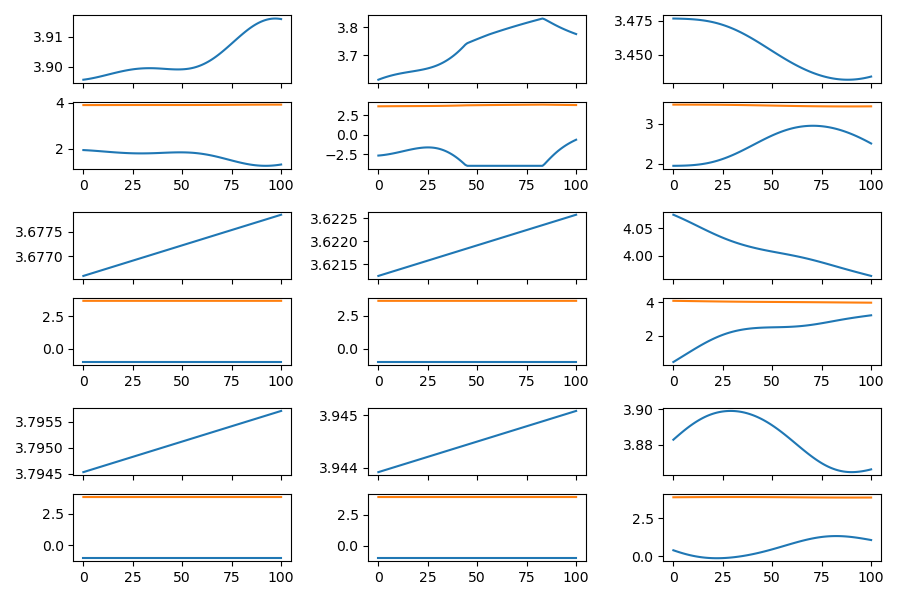

In [ ]:
dls.show_batch()

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()